<a href="https://colab.research.google.com/github/maskot1977/PythonCourse2019/blob/master/kumantic5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFilter
from itertools import product

def draw_bear(n_bear=1): # ランダムにクマさんの画像を生成する
    r = g = b = 250
    im = Image.new('RGB', (400, 400), (r, g, b))
    draw = ImageDraw.Draw(im)

    for _ in range(random.randint(-1, 0)):
        r = random.randint(10, 200)
        g = random.randint(10, 200)
        b = random.randint(10, 200)
        x1 = random.randint(0, 400)
        y1 = random.randint(0, 400)
        dx = random.randint(10, 50)
        dy = random.randint(10, 50)
        draw.ellipse((x1, y1, x1+dx, y1+dy), fill=(r, g, b))

    for _ in range(n_bear):
        r = g = b = 1
        center_x = 200
        center_y = 200
        wx = 50
        wy = 50
        dx1 = 90
        dx2 = 20
        dy1 = 90
        dy2 = 20
        dx3 = 15
        dy3 = 100
        dy4 = 60
        shape1 = (center_x - wx, center_y - wy, center_x + wx, center_y + wy)
        shape2 = (center_x - dx1, center_y - dy1, center_x - dx2, center_y - dy2)
        shape3 = (center_x + dx2, center_y - dy1, center_x + dx1, center_y - dy2)
        shape4 = (center_x - dx3, center_y - dy3, center_x + dx3, center_y - dy4)

        zoom = 0.2 + random.random() * 0.5
        center_x = random.randint(-30, 250)
        center_y = random.randint(-30, 250)

        shape1 = modify(shape1, zoom=zoom, center_x=center_x, center_y=center_y)
        shape2= modify(shape2, zoom=zoom, center_x=center_x, center_y=center_y)
        shape3 = modify(shape3, zoom=zoom, center_x=center_x, center_y=center_y)
        shape4 = modify(shape4, zoom=zoom, center_x=center_x, center_y=center_y)

        draw.ellipse(shape1, fill=(r, g, b))
        draw.ellipse(shape2, fill=(r, g, b))
        draw.ellipse(shape3, fill=(r, g, b))
        #draw.ellipse(shape4, fill=(r, g, b))

    return im

def modify(shape, zoom=1, center_x=0, center_y=0):
    x1, y1, x2, y2 = np.array(shape) * zoom
    return (x1 + center_x, y1 + center_y, x2 + center_x, y2 + center_y)

class Noise: # クマさんの画像にノイズを乗せる
    def __init__(self, input_image):
        self.input_image = input_image
        self.input_pix = self.input_image.load()
        self.w, self.h = self.input_image.size

    def saltpepper(self, salt=0.05, pepper=0.05):
        output_image = Image.new("RGB", self.input_image.size)
        output_pix = output_image.load()

        for x, y in product(*map(range, (self.w, self.h))):
            r = random.random()
            if r < salt:
                output_pix[x, y] = (255, 255, 255)
            elif r > 1 - pepper:
                output_pix[x, y] = (  0,   0,   0)
            else:
                output_pix[x, y] = self.input_pix[x, y]
        return output_image

# クマさんの画像をセマンティック・セグメンテーション用の教師データに加工する
def getdata_for_semantic_segmentation(im): 
    x_im = im.filter(ImageFilter.CONTOUR)
    im2 = Noise(input_image=x_im)
    x_im = im2.saltpepper()
    a_im = np.asarray(im)
    y_im = Image.fromarray(np.where(a_im == 1, 255, 0).astype(dtype='uint8'))
    return x_im, y_im

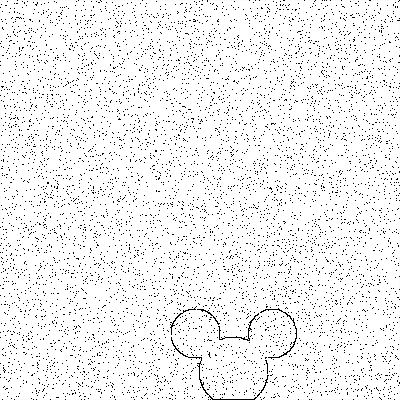

In [0]:
x_im, y_im = getdata_for_semantic_segmentation(draw_bear())
x_im

In [0]:
%%time
X_data = [] # 画像データ格納用
Y_data = [] # 正解データ格納用
for i in range(1000): # 画像を1０００個生成する
    x_im, y_im = getdata_for_semantic_segmentation(draw_bear())
    X_data.append(x_im) # 画像データ
    Y_data.append(y_im) # 正解データ

CPU times: user 1min 13s, sys: 1.15 s, total: 1min 14s
Wall time: 1min 15s


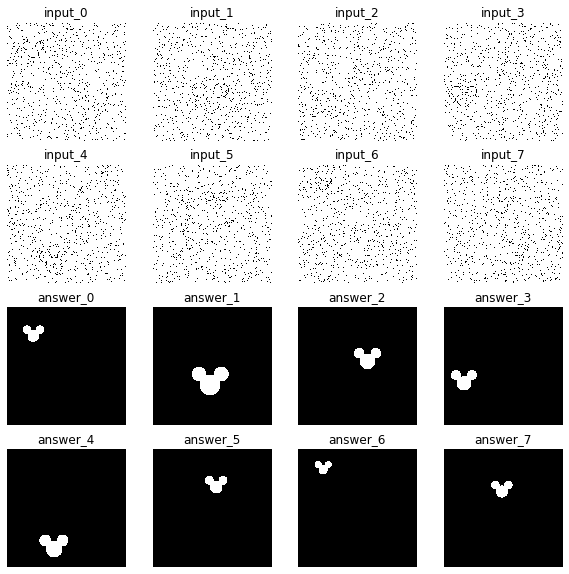

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.axis('off')
    if i < 8: # 画像データのトップ８を表示
        ax.set_title('input_{}'.format(i))
        ax.imshow(X_data[i],cmap=plt.cm.gray, interpolation='none')
    else: # 正解データのトップ８を表示
        ax.set_title('answer_{}'.format(i - 8))
        ax.imshow(Y_data[i - 8],cmap=plt.cm.gray, interpolation='none')
plt.show()

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 画像データと正解データを ndarray に変換
X_a = np.array([[np.asarray(x).transpose((2, 0, 1))[0]] for x in X_data])
Y_a = np.array([[np.asarray(y).transpose((2, 0, 1))[0]] for y in Y_data])

# ndarray の画像データと正解データを tensor に変換
X_t = torch.tensor(X_a, dtype = torch.float32)               
Y_t = torch.tensor(Y_a, dtype = torch.float32)

# PyTorch で学習するためにデータローダーに格納
data_set = TensorDataset(X_t, Y_t)
data_loader = DataLoader(data_set, batch_size = 100, shuffle = True)

In [0]:
from torch import nn, optim
from torch.nn import functional as F
class Kuma(nn.Module):
    def __init__(self):
        super(Kuma, self).__init__()
        # エンコーダー部分
        self.encode1 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 1, out_channels = 6, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(6)
              ])
        self.encode2 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 6, out_channels = 16, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(16)
              ])
        self.encode3 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(32)
              ])
        
        self.encode4 = nn.Sequential(
            *[
              nn.Conv2d(
                  in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(64)
              ])

        # デコーダー部分
        self.decode4 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(32)
              ])
        self.decode3 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(16)
              ])
        self.decode2 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 16, out_channels = 6, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(6)
              ])
        self.decode1 = nn.Sequential(
            *[
              nn.ConvTranspose2d(
                  in_channels = 6, out_channels = 1, kernel_size = 3, padding = 1),
              ])

    def forward(self, x):
        # エンコーダー部分
        dim_0 = x.size()      
        x = F.relu(self.encode1(x))
        x, idx_1 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)

        dim_1 = x.size() 
        x = F.relu(self.encode2(x))
        x, idx_2 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)

        dim_2 = x.size()
        x = F.relu(self.encode3(x)) 
        x, idx_3 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)

        dim_3 = x.size()
        x = F.relu(self.encode4(x)) 
        x, idx_4 = F.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)

        # デコーダー部分
        x = F.max_unpool2d(x, idx_4, kernel_size = 2, stride = 2, output_size = dim_3)
        x = F.relu(self.decode4(x))

        x = F.max_unpool2d(x, idx_3, kernel_size = 2, stride = 2, output_size = dim_2)
        x = F.relu(self.decode3(x))

        x = F.max_unpool2d(x, idx_2, kernel_size = 2, stride = 2, output_size = dim_1)           
        x = F.relu(self.decode2(x))

        x = F.max_unpool2d(x, idx_1, kernel_size = 2, stride = 2, output_size = dim_0)           
        x = F.relu(self.decode1(x))

        x = torch.sigmoid(x)                                     

        return x

Wed Feb 26 07:13:00 UTC 2020
epoch: 0  loss: 1438.7759155273438
Wed Feb 26 07:15:46 UTC 2020
epoch: 1  loss: 1436.6644165039063
Wed Feb 26 07:18:38 UTC 2020
epoch: 2  loss: 1436.4984252929687
Wed Feb 26 07:21:30 UTC 2020
epoch: 3  loss: 1436.4854736328125
Wed Feb 26 07:24:21 UTC 2020
epoch: 4  loss: 1436.481884765625
Wed Feb 26 07:27:12 UTC 2020
epoch: 5  loss: 1436.4798095703125
Wed Feb 26 07:30:03 UTC 2020
epoch: 6  loss: 1436.48046875
Wed Feb 26 07:32:52 UTC 2020
epoch: 7  loss: 1436.47890625
Wed Feb 26 07:35:40 UTC 2020
epoch: 8  loss: 1436.4782104492188
Wed Feb 26 07:38:31 UTC 2020
epoch: 9  loss: 1436.4782104492188
Wed Feb 26 07:41:20 UTC 2020
epoch: 10  loss: 1436.4763305664062
Wed Feb 26 07:44:11 UTC 2020
epoch: 11  loss: 1436.4760620117188
Wed Feb 26 07:47:04 UTC 2020
epoch: 12  loss: 1436.4753662109374
Wed Feb 26 07:49:56 UTC 2020
epoch: 13  loss: 1436.4747802734375
Wed Feb 26 07:52:49 UTC 2020
epoch: 14  loss: 1436.4748657226562
Wed Feb 26 07:55:38 UTC 2020
epoch: 15  loss: 

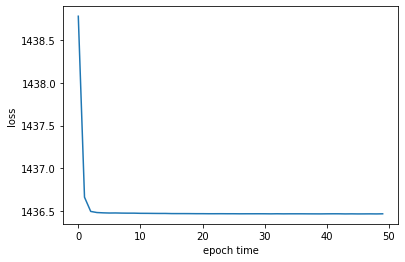

CPU times: user 2h 5min 48s, sys: 2min 22s, total: 2h 8min 11s
Wall time: 2h 21min 30s


In [0]:
%%time

kuma = Kuma()
loss_fn = nn.MSELoss()                               
optimizer = optim.Adam(kuma.parameters(), lr = 0.01)

total_loss_history = []                                     
epoch_time = 50
for epoch in range(epoch_time):
    !date
    total_loss = 0.0                          
    kuma.train()
    for i, (XX, yy) in enumerate(data_loader):
        optimizer.zero_grad()       
        y_pred = kuma(XX)
        loss = loss_fn(y_pred, yy)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("epoch:",epoch, " loss:", total_loss/(i + 1))
    total_loss_history.append(total_loss/(i + 1))

plt.plot(total_loss_history)
plt.ylabel("loss")
plt.xlabel("epoch time")
plt.savefig("total_loss_history")
plt.show()

In [0]:
X_test = [] # テスト用の画像データを格納
Y_test = [] # テスト用の正解データを格納
Z_test = [] # テスト用の予測結果を格納

for i in range(100): # 学習に用いなかった新規データを１００個生成
    x_im, y_im = getdata_for_semantic_segmentation(draw_bear())
    X_test.append(x_im)
    Y_test.append(y_im)

# テスト用の画像データをPyTorch用に整形
X_test_a = np.array([[np.asarray(x).transpose((2, 0, 1))[0]] for x in X_test])
X_test_t = torch.tensor(X_test_a, dtype = torch.float32)

# 学習済みのモデルを使って予測値を計算
Y_pred = kuma(X_test_t)

# 予測値を ndarray として格納
for pred in Y_pred:
    Z_test.append(pred.detach().numpy())

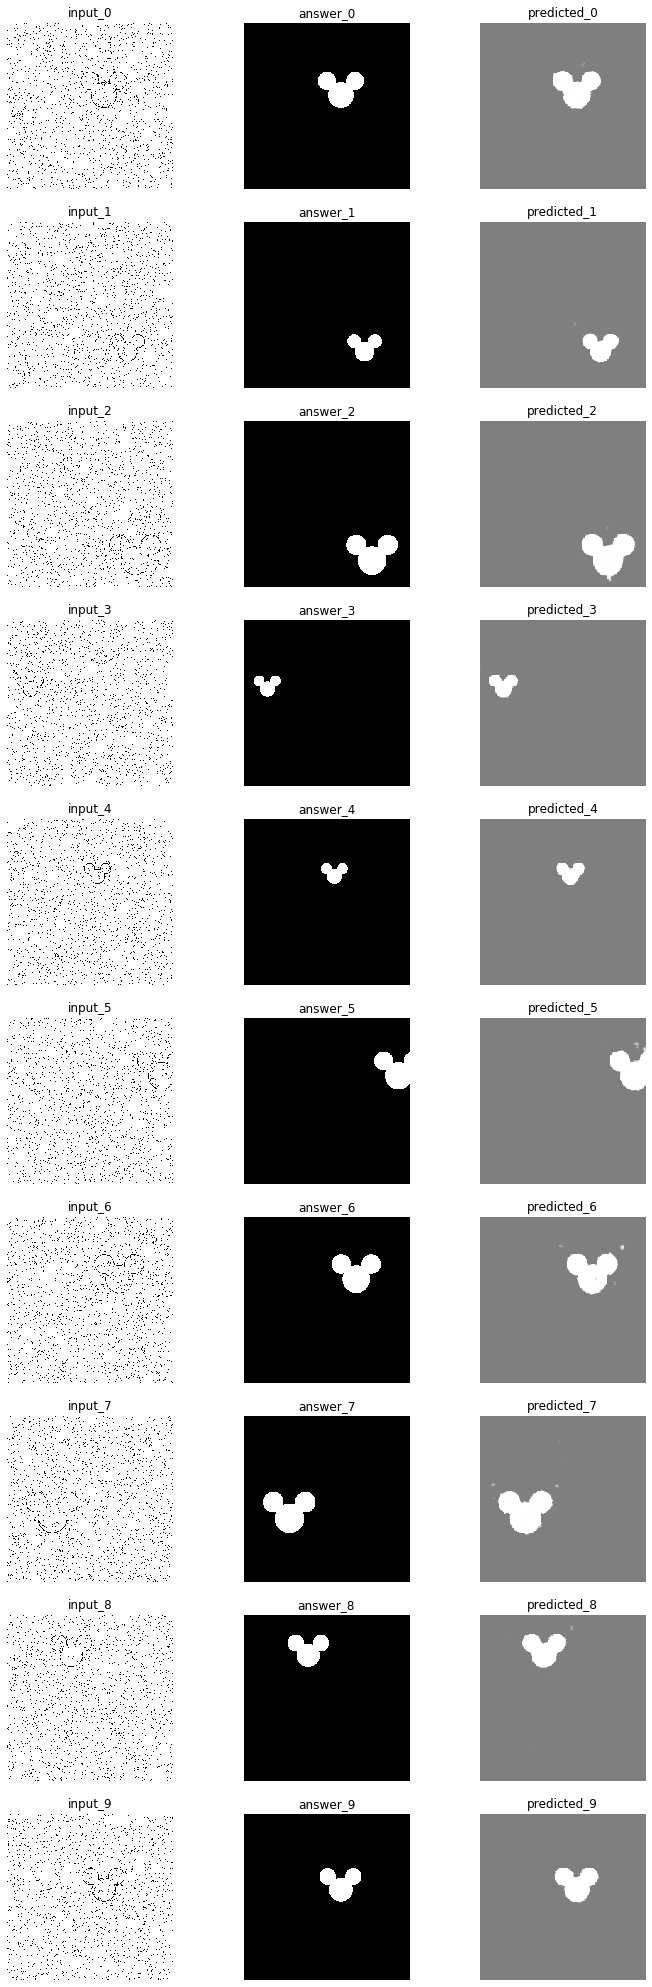

In [0]:
# データの先頭１０個に対して、画像データ、正解データ、予測値を描画
fig = plt.figure(figsize=(12,36))
for i in range(10):
    ax = fig.add_subplot(10, 3, (i * 3)+1)
    ax.axis('off')
    ax.set_title('input_{}'.format(i))
    ax.imshow(X_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+2)
    ax.axis('off')
    ax.set_title('answer_{}'.format(i))
    ax.imshow(Y_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+3)
    ax.axis('off')
    ax.set_title('predicted_{}'.format(i))
    yp2 = Y_pred[i].detach().numpy()[0] * 255
    z_im = Image.fromarray(np.array([yp2, yp2, yp2]).transpose((1, 2, 0)).astype(dtype='uint8'))
    ax.imshow(z_im)
plt.show()

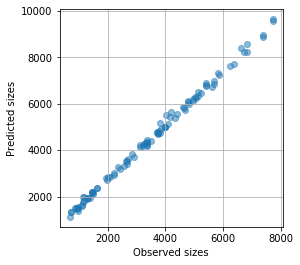

In [0]:
A_ans = []
A_pred = []
for yt, zt in zip(Y_test, Z_test):
    # 正解の白の面積（ベクトルが３色分あるので３で割る）
    A_ans.append(np.where(np.asarray(yt) > 0.5, 1, 0).sum() / 3) 
    A_pred.append(np.where(np.asarray(zt) > 0.5, 1, 0).sum()) # 予測値の白の面積

plt.figure(figsize=(4, 4))
plt.scatter(A_ans, A_pred, alpha=0.5)
plt.grid()
plt.xlabel('Observed sizes')
plt.ylabel('Predicted sizes')
#plt.xlim([0, 1700])
#plt.ylim([0, 1700])
plt.show()

In [0]:
torch.save(kuma.state_dict(), "kuma_050_20200226.pytorch")

In [3]:
import torch
kuma = Kuma()
kuma.load_state_dict(torch.load("kuma_050_20200226.pytorch"))

<All keys matched successfully>

In [0]:
X_test = [] # テスト用の画像データを格納
Y_test = [] # テスト用の正解データを格納
Z_test = [] # テスト用の予測結果を格納

for i in range(100): # 学習に用いなかった新規データを１００個生成
    x_im, y_im = getdata_for_semantic_segmentation(draw_bear(n_bear=random.randint(0, 5)))
    X_test.append(x_im)
    Y_test.append(y_im)

# テスト用の画像データをPyTorch用に整形
X_test_a = np.array([[np.asarray(x).transpose((2, 0, 1))[0]] for x in X_test])
X_test_t = torch.tensor(X_test_a, dtype = torch.float32)

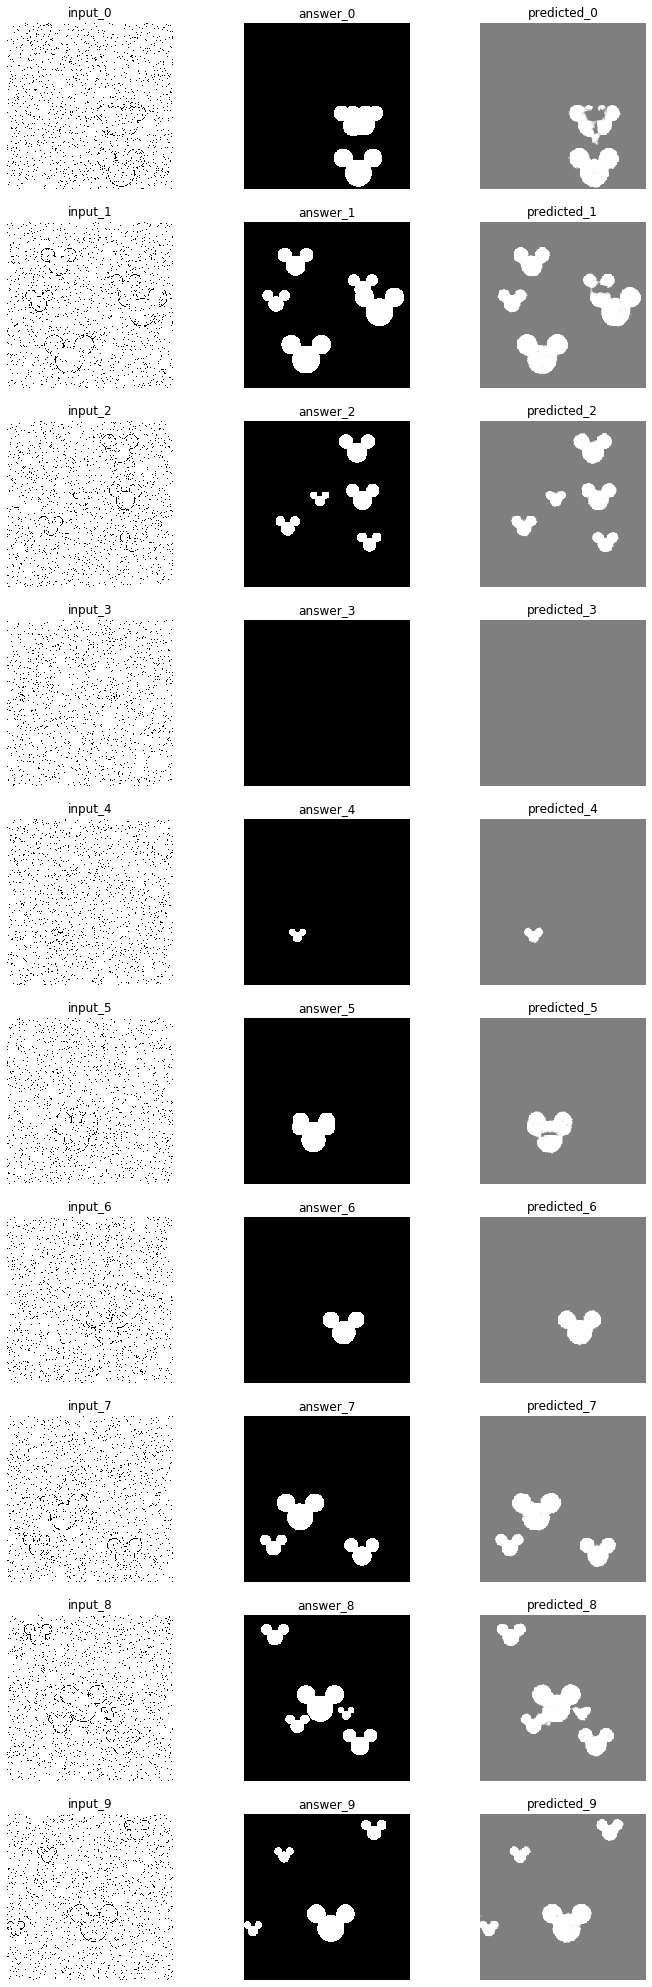

In [8]:
import matplotlib.pyplot as plt
# 学習済みのモデルを使って予測値を計算
Y_pred = kuma(X_test_t)

# 予測値を ndarray として格納
for pred in Y_pred:
    Z_test.append(pred.detach().numpy())

# データの先頭１０個に対して、画像データ、正解データ、予測値を描画
fig = plt.figure(figsize=(12,36))
for i in range(10):
    ax = fig.add_subplot(10, 3, (i * 3)+1)
    ax.axis('off')
    ax.set_title('input_{}'.format(i))
    ax.imshow(X_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+2)
    ax.axis('off')
    ax.set_title('answer_{}'.format(i))
    ax.imshow(Y_test[i])
    ax = fig.add_subplot(10, 3, (i * 3)+3)
    ax.axis('off')
    ax.set_title('predicted_{}'.format(i))
    yp2 = Y_pred[i].detach().numpy()[0] * 255
    z_im = Image.fromarray(np.array([yp2, yp2, yp2]).transpose((1, 2, 0)).astype(dtype='uint8'))
    ax.imshow(z_im)
plt.show()

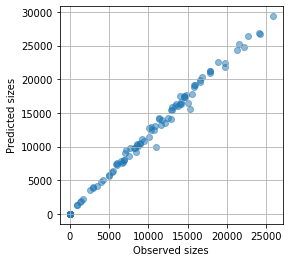

In [9]:
A_ans = []
A_pred = []
for yt, zt in zip(Y_test, Z_test):
    # 正解の白の面積（ベクトルが３色分あるので３で割る）
    A_ans.append(np.where(np.asarray(yt) > 0.5, 1, 0).sum() / 3) 
    A_pred.append(np.where(np.asarray(zt) > 0.5, 1, 0).sum()) # 予測値の白の面積

plt.figure(figsize=(4, 4))
plt.scatter(A_ans, A_pred, alpha=0.5)
plt.grid()
plt.xlabel('Observed sizes')
plt.ylabel('Predicted sizes')
#plt.xlim([0, 1700])
#plt.ylim([0, 1700])
plt.show()